###### loading data tutorial: https://www.youtube.com/watch?v=WvoLTXIjBYU&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN&index=3
###### mobilenet/transfer learning tutorial: https://deeplizard.com/learn/video/FNqp4ZY0wDY
###### and https://www.youtube.com/watch?v=FNqp4ZY0wDY
###### general transfer learning tutorial: https://www.youtube.com/watch?v=WJZoywOG1cs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# DATADIR = "/content/drive/MyDrive/EML/Guitar_Chord_Data_Set/test_phone"
# CATEGORIES = ["C","D","Em"]
DATADIR = "/content/drive/MyDrive/EML/Guitar_Chord_Data_Set/phoneV5"
CATEGORIES = ["C","D","Em", "F", "G"]

#DATADIR = "/content/drive/MyDrive/EML/Sign_Language_Dataset"
#CATEGORIES = ["0","1","2", "3", "4", "5", "6", "7", "8", "9"]
print("Number of Categories:", len(CATEGORIES))

Number of Categories: 5


In [5]:
train_dir = DATADIR

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))

train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
test_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 1101 files belonging to 5 classes.
Number of train batches: 35
Number of train batches: 21
Number of validation batches: 7
Number of test batches: 7


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

USE DATA AUGMENTATION:

In [7]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
base_model = tf.keras.applications.MobileNetV2(include_top=False)
# model.summary()

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 7, 7, 1280)
(32, 1280)


In [11]:
from tensorflow.keras.layers import Dense

base_model.trainable = False

prediction_layer = Dense(len(CATEGORIES), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
new_model = tf.keras.Model(inputs, outputs)

In [12]:
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [13]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405  

In [14]:
initial_epochs = 10

loss0, accuracy0 = new_model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = new_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

7/7 [==============================] - 6s 320ms/step - loss: 1.9065 - accuracy: 0.2432
initial loss: 1.91
initial accuracy: 0.25
Epoch 1/10
21/21 [==============================] - 125s 6s/step - loss: 1.6299 - accuracy: 0.3185 - val_loss: 1.0861 - val_accuracy: 0.6205
Epoch 2/10
21/21 [==============================] - 17s 480ms/step - loss: 1.0607 - accuracy: 0.5666 - val_loss: 0.6795 - val_accuracy: 0.8705
Epoch 3/10
21/21 [==============================] - 17s 477ms/step - loss: 0.6823 - accuracy: 0.7948 - val_loss: 0.4896 - val_accuracy: 0.9420
Epoch 4/10
21/21 [==============================] - 17s 474ms/step - loss: 0.5174 - accuracy: 0.8560 - val_loss: 0.4009 - val_accuracy: 0.9286
Epoch 5/10
21/21 [==============================] - 17s 485ms/step - loss: 0.4212 - accuracy: 0.9020 - val_loss: 0.3032 - val_accuracy: 0.9688
Epoch 6/10
21/21 [==============================] - 17s 477ms/step - loss: 0.3278 - accuracy: 0.9296 - val_loss: 0.2457 - val_accuracy: 0.9911
Epoch 7/10
21/2

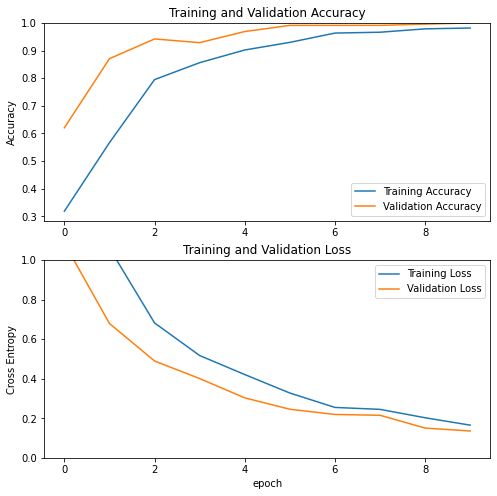

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine Tune Model:

In [16]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

new_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001/10),
              metrics=['accuracy'])

new_model.summary()

len(new_model.trainable_variables)

Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)       

56

In [17]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = new_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks =[earlystopping])


Epoch 10/20
21/21 [==============================] - 22s 521ms/step - loss: 0.1508 - accuracy: 0.9648 - val_loss: 0.0399 - val_accuracy: 1.0000
Epoch 11/20
21/21 [==============================] - 18s 491ms/step - loss: 0.0364 - accuracy: 0.9984 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 12/20
21/21 [==============================] - 17s 486ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 13/20
21/21 [==============================] - 17s 488ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 14/20
21/21 [==============================] - 18s 492ms/step - loss: 0.0240 - accuracy: 0.9931 - val_loss: 0.0122 - val_accuracy: 0.9955
Epoch 15/20
21/21 [==============================] - 18s 489ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 16/20
21/21 [==============================] - 18s 497ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy:

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

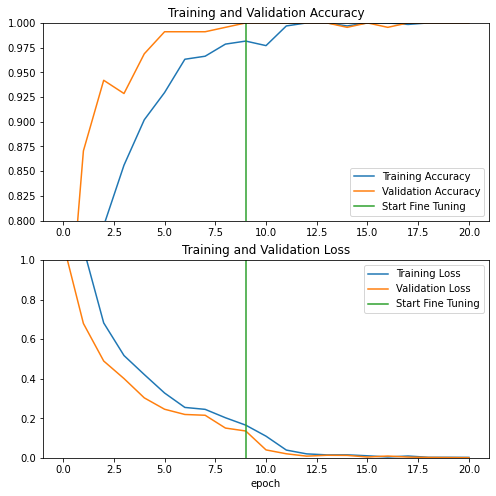

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
saved_model_dir = '/content/drive/MyDrive/EML/Guitar_Model_V4/'
tf.saved_model.save(new_model, saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
# print(tflite_model)
open('/content/drive/MyDrive/EML/Guitar_Model_V4/model.tflite', 'wb').write(tflite_model)
# print(labels)
labels = '\n'.join(sorted(CATEGORIES))
open('/content/drive/MyDrive/EML/Guitar_Model_V4/labels.txt', 'w').write(labels)
# open('/content/drive/MyDrive/EML/Guitar_Model_V2/history.txt', 'w').write(history)
# open('/content/drive/MyDrive/EML/Guitar_Model_V2/history_fine.txt', 'w').write(history_fine)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/EML/Guitar_Model_V4/assets


10

Confusion matrix, without normalization
[[42  0  0  0  0]
 [ 0 42  0  0  0]
 [ 0  0 34  0  0]
 [ 0  0  0 49  0]
 [ 0  0  0  0 57]]


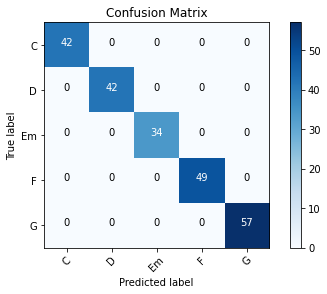

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(new_model.predict(x), axis=-1)])
  labels = np.concatenate([labels, y.numpy()]).astype(int)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true=labels, y_pred=predictions)
plot_confusion_matrix(cm=cm, classes=CATEGORIES, title='Confusion Matrix')